# <center>Graphene quantum Hall effect</center>
<hr>

In [1]:
import kwant
import scipy
import numpy as np
import random
from matplotlib import pyplot as plt

### Fundamental constants

In [2]:
h = 6.626069e-34  # Planck constant (Js)
h_bar =h/(2*np.pi) # With h_bar oom larger and Bmax=30, it works perfectly

# Scaling factor of 10 required --> h_bar normal, Bmax=3

e = 1.602e-19      # electron charge (C)
c = 299792458       # Light celerity (m/s)
kB = 1.3806503e-23  # Boltzmann constant (kg m2/Ks2)
m_e = 9.1e-31       # electron mass (kg)

### Scaling

In [3]:
asquare = 1e-9 # [m] a is the lattice parameter
tsquare = 1 # [eV] t is the hopping parameter

# scaling

scaling = 4 # scaling factor
a = asquare * scaling
t = tsquare / scaling

### Geometrical parameters

In [4]:
W=200e-9 ; L = 1000e-9 # width and length of the electronic system

# For width smaller than 50 nm, the script does not work since the magnetic length is 30 nm so wf start to overlap (?)
# Also for width slightly larger than that, the steps in the Hall resistance are lost. For w=200 nm they are recovered.

width_lead=20e-9                                         
posL = 350e-9 # pos of the leads along x
lead_ext = posL + width_lead / 2
lead_int = posL - width_lead / 2

flag=0

#### Geometry of the device

In [5]:
def geom(pos):
    x, y = pos
    return abs(x) < L / 2 and abs(y) < W / 2

#### Geometry of the leads

In [6]:
def lead_shape(pos):
    x, y = pos
    return -W/2 < y < W/2


def lead_shape_left(pos):
    x, y = pos
    return -lead_ext < x < -lead_int


def lead_shape_right(pos):
    x, y = pos    
    return lead_int < x < lead_ext

#### Potentials & Disorder

In [7]:
def step_potential(x, y):

    region_1 = 150e-9
    w_pot = 0
    
    in_region_1 = abs(x) < region_1 and abs(y) < W / 2 - w_pot
    
    return in_region_1 * v_tip


def smooth_potential(x, y):
    
    region_1 = 150e-9
    w_pot = 0
    
    in_region_1 = abs(x) < region_1 and abs(y) < W / 2 - w_pot
    
    return in_region_1 * np.cos(abs(x) * np.pi / (2 * region_1)) * (v_tip - 0.01)


def stair_potential(x, y):
    
    region_1 = 50e-9
    region_2 = 200e-9
    w_pot = 0 

    in_region_2 = abs(x) < region_2 and abs(y) < W / 2 - w_pot
    in_region_1 = abs(x) < region_1 and abs(y) < W / 2 - w_pot
    
    return (in_region_1 + in_region_2) * v_tip / 2


def disorder(pos):
    x, y = pos
    
    #pot=0.05*random.uniform(0,t)
    pot=0
    
    flag = 1 if (pot != 0) else 0
    
    return pot

Introducing a disorder of 0.01 leads to peaks in longitudinal resistance but we retain anyway plateaus in Hall resistance.

#### Defining onsite and hopping parameters

In [8]:
def onsite(site):
    """
    Definition of the potential. To reach the bottom of the conduction band, the potential is set at 4*t.
    A zone of potential v_tip (above the bottom of the conduction band) can be defined in a given zone 
    (square or circle here). 
    """
    x, y = site.pos
    
        
    return -stair_potential(x, y) + disorder(site)

#### Hopping parameter

In [9]:
def hopping(site_i, site_j):  
    
    xi, yi = site_i.pos
    xj, yj = site_j.pos
    
    # The definition of hop to include the magnetic field Bfield in the definition of the hopping parameter
    
    hop = t * np.exp(1j * e * Bfield * (yi + yj) * (xj - xi) / (2 * h_bar))
    
    return hop

## Building the system

In [10]:
def sys_builder():
    
    graphene = kwant.lattice.general([(np.sqrt(3) * a, 0), (0, 3 * a)], 
                                     [(a * np.sqrt(3) / 2, 0), (0, a / 2), (0, 3 * a / 2), (a * np.sqrt(3) / 2, 2 * a)], 
                                     norbs = 1)
    
    A, B, C, D = graphene.sublattices
      
    sys = kwant.Builder()
    sys[graphene.shape(geom, (0,0))] = onsite
    
    hoppings = (((0, 0), B, A), ((0, 0), C, B), ((0, 0), D, C), ((-1, 0), A, B), ((-1, 0), D, C), ((0, 1), A, D)) 
    sys[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = hopping

# Schematic of the Hall bar
#   ,----------o----Vxx----.--------------.
#   |  Lead 3  |           |  Lead 5    __|__
#  Vxy     __|   |_______|   |__        '''''    (ground)
#   |               I
#   | Lead 1      ----->      Lead 2
#   |      __     _______     __
#   |        |   |       |   |
#   |  Lead 4  |               Lead 6
#   `----------'
    
    """ Lead 1 """
    sym0 = kwant.TranslationalSymmetry(graphene.vec((-1, 0)))
    lead0 = kwant.Builder(sym0)
    lead0[graphene.shape(lead_shape, (0, 0))] = 0 # is it really zero here? I think yes
    lead0[graphene.neighbors()] = hopping

    """ Lead 2 """
    sym1 = kwant.TranslationalSymmetry(graphene.vec((1, 0)))
    lead1 = kwant.Builder(sym1)
    lead1[graphene.shape(lead_shape, (0, 0))] = 0    
    lead1[graphene.neighbors()] = hopping

    """ Lead 3 """
    sym2 = kwant.TranslationalSymmetry(graphene.vec((0, 1)))
    lead2 = kwant.Builder(sym2)
    lead2[graphene.shape(lead_shape_left, (-posL, 0))] = 0
    lead2[graphene.neighbors()] = hopping

    """ Lead 4 """
    sym3 = kwant.TranslationalSymmetry(graphene.vec((0, -1)))
    lead3 = kwant.Builder(sym3)
    lead3[graphene.shape(lead_shape_left, (-posL, 0))] = 0
    lead3[graphene.neighbors()] = hopping

    """ Lead 5 """ 
    lead4 = kwant.Builder(sym2)
    lead4[graphene.shape(lead_shape_right, (posL, 0))] = 0
    lead4[graphene.neighbors()] = hopping
    
    """Lead 6"""
    lead5 = kwant.Builder(sym3)
    lead5[graphene.shape(lead_shape_right, (posL, 0))] = 0
    lead5[graphene.neighbors()] = hopping
    
    """ The leads are attached """
    sys.attach_lead(lead0)
    sys.attach_lead(lead1)
    sys.attach_lead(lead2)
    sys.attach_lead(lead3)
    sys.attach_lead(lead4)
    sys.attach_lead(lead5)
 
    sys = sys.finalized()
    
    return sys   

In [11]:
sys = sys_builder()

#### Plotting the system

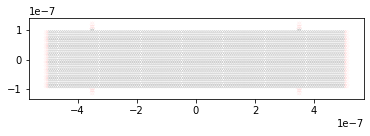

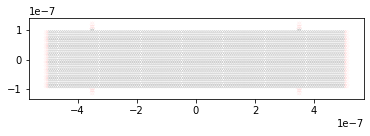

In [12]:
kwant.plot(sys, site_size = 1e-9)

## Electronic properties

In [13]:
Ef = 0.17 # maybe it could be modified
Bfield = 1.82
v_tip = -0.1 # max potential below the tip

params = dict(Bfield = Bfield, v_tip = v_tip) # params take the magnetic field as a parameter for the function hopping

In [14]:
# The wavelength must be (much more) larger than the lattice parameter 
# We can also check the width of the device w.r.t. the magnetic length, which is the extension of the wf 

lambda_F = 3 * np.pi * t* a /abs(Ef) # computation of the wavelength
mag_length=np.sqrt(h_bar/(e*Bfield))

if lambda_F/a < 2:
    print('Warning : lambda_F must be larger than the lattice parameter a')
    
if mag_length > W/2:
    print('Warning : wavefunctions extend across the whole bar')

#### Visualization of the Landau Levels

LL-4 = -0.22308232368408085
LL-3 = -0.19319495944567694
LL-2 = -0.15774302383986594
LL-1 = -0.11154116184204042
LL0 = -0.0
LL1 = 0.11154116184204042
LL2 = 0.15774302383986594
LL3 = 0.19319495944567694
LL4 = 0.22308232368408085
Fermi Energy =0.17


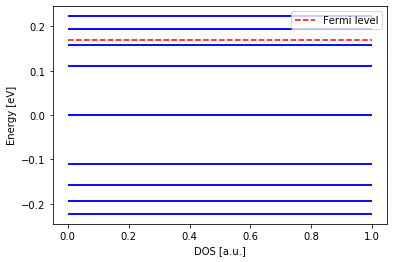

In [15]:
ll_num = 5
ll_indexes = np.arange(0, ll_num)
lls = -3 * t * a * np.sqrt(e  * ll_indexes * Bfield / (2 * h_bar))
lls = np.append(lls[::-1], -lls[1:])

plt.figure()

for n, ll in enumerate(lls):
     
    # Landau levels as a function of the magnetic field Bfield and the Landau level label n
    plt.hlines(ll, 0, 1, color="b")
    plt.hlines(ll, 0, 1, color="b")
    print(f'LL{n - (ll_num - 1)} = {ll}')
    
print (f'Fermi Energy ={Ef}')
    
plt.hlines(Ef, 0, 1, colors='r', linestyles="dashed", label='Fermi level') # to plot the Fermi energy (in red)
plt.xlabel('DOS [a.u.]')
plt.ylabel('Energy [eV]')
plt.legend()
plt.show()

### Visualization of the LL + step potential

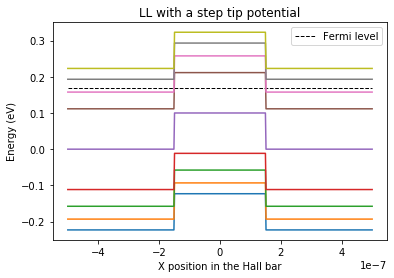

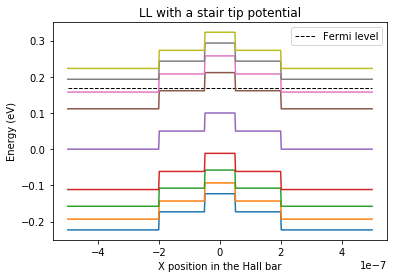

In [16]:
N=500
x_positions = np.linspace(-L / 2, L / 2, N) 
ll_step_matrix = np.zeros((2 * ll_num - 1, N))
ll_stair_matrix = np.zeros((2 * ll_num - 1, N))

for x_idx, x_pos in enumerate(x_positions):
    ll_step_matrix[:, x_idx] = lls[:] - step_potential(x_pos, 0)
    ll_stair_matrix[:, x_idx] = lls[:] - stair_potential(x_pos, 0)
    
plt.figure()
for ll_row in ll_step_matrix:
    
    plt.plot(x_positions, ll_row)

plt.hlines(Ef, -L/2, L/2, colors='k', linestyles="dashed", label='Fermi level', linewidth=1)
plt.xlabel('X position in the Hall bar')
plt.ylabel('Energy (eV)')
plt.title('LL with a step tip potential')
plt.legend()

plt.figure()
for ll_row in ll_stair_matrix:
    
    plt.plot(x_positions, ll_row)

plt.hlines(Ef, -L/2, L/2, colors='k', linestyles="dashed", label='Fermi level', linewidth=1)
plt.xlabel('X position in the Hall bar')
plt.ylabel('Energy (eV)')
plt.title('LL with a stair tip potential')
plt.legend()

plt.show()

### Current and wf density

#### Wave function

In [17]:
wfs = kwant.wave_function(sys, energy=Ef, params = params) # the wf is obtained by giving the parameters in arguments
scattering_wf = wfs(0) # all scattering wave functions from lead 0

#### Current density


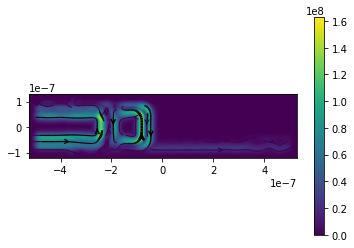

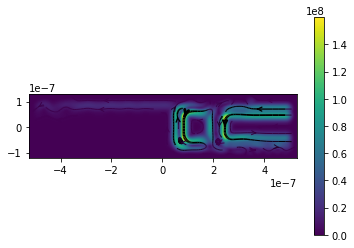

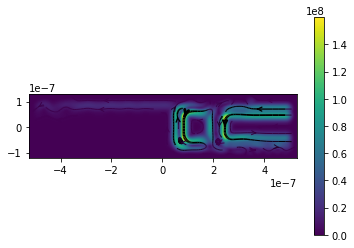

In [18]:
# To obtain edge states, a strong field is required, in order to be in the high magnetic field regime. 2 T gives edge states, 
# 0.1 T gives normal conduction

J0 = kwant.operator.Current(sys)
wf_left = wfs(0)
wf_right = wfs(1)

current = sum(J0(p, params = params) for p in wf_left) # to sum over all the lead's mode
current_right=sum(J0(p, params = params) for p in wf_right)

kwant.plotter.current(sys, current, cmap='viridis')
kwant.plotter.current(sys, current_right, cmap='viridis')

To have clear current plots you have to make sure the potential zone does not overlap with the leads.

### Plotting Hall conductance as function of the back gate voltage applied (Fermi level)

In [19]:
Ef_min = 0.05
Ef_max = 0.18 
num_it = 100 # discretization of the fermi level 
num_leads = 6

fermi_energies = np.linspace(Ef_min, Ef_max, num_it)

Rxx = np.zeros(num_it)
Rxy = np.zeros(num_it)

params = dict(Bfield = Bfield, v_tip = v_tip)

for idx, en in enumerate(fermi_energies):
        
    try:    
        s = kwant.smatrix(sys, energy=en, params=params)
        
        # conductance matrix from the transmission matrix
        cond = np.array([[s.transmission(i, j) for j in range(num_leads)] for i in range(num_leads)])
        
        cond -= np.diag(cond.sum(axis=0))
        
        cm = s.conductance_matrix()[:-1, :-1]
        
        R = np.linalg.solve(cm, [1, -1, 0, 0, 0])
        Rxx[idx] = R[3]
        Rxy[idx] = R[4]
    
    except Exception as e:
        print(f'problem encountered at iteration {idx} with the following error: \n {e}')

### Hall resistivity vs Fermi Energy

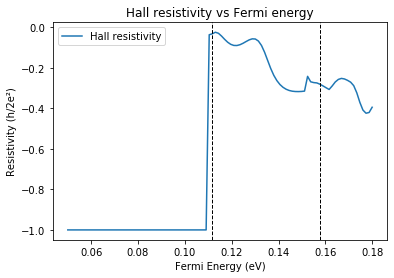

In [20]:
plt.figure()
plt.title("Hall resistivity vs Fermi energy")
plt.plot(fermi_energies, Rxy, label='Hall resistivity')

for _, ll in enumerate(lls):
    if(Ef_min < ll < Ef_max):
        plt.axvline(x=ll, color='k', linestyle='--', linewidth=1)
        
plt.xlabel('Fermi Energy (eV)')
plt.ylabel('Resistivity (h/2e²)')
plt.legend()
plt.show()

### Longitudinal resistivity vs Fermi energy (with non-zero tip potential)

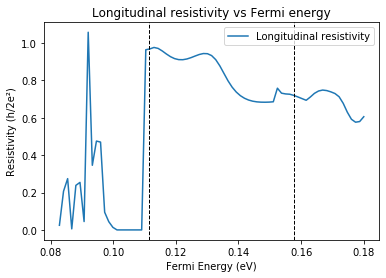

In [21]:
# indices=np.where(Rxx_Ef > 10)
# Rxx_Ef[indices] = 0
overhead_amount = 25
plt.figure()
plt.title("Longitudinal resistivity vs Fermi energy")
plt.plot(fermi_energies[overhead_amount:], Rxx[overhead_amount:], label='Longitudinal resistivity')

for _, ll in enumerate(lls):
    if(Ef_min < ll < Ef_max):
        plt.axvline(x=ll, color='k', linestyle='--', linewidth=1)
        
plt.xlabel('Fermi Energy (eV)')
plt.ylabel('Resistivity (h/2e²)')
plt.legend()
plt.show()

### Plotting Hall conductivity as function of local potential (tip potential)

In [22]:
v_tip_min=-0.17
v_tip_max=0.09
n_iter_v_tip =100;

v_tip_arr = np.linspace(v_tip_min,v_tip_max,n_iter_v_tip)
Rxx_v_tip = np.zeros([len(v_tip_arr),1])
Rxy_v_tip = np.zeros([len(v_tip_arr),1])

for idx, v_tip in enumerate(v_tip_arr):
        
    try:
        params = dict(Bfield = Bfield, v_tip = v_tip)
        s = kwant.smatrix(sys, energy=Ef, params=params)
        
        #conductance matrix from the transmission matrix
        cond = np.array([[s.transmission(i, j) for j in range(num_leads)] for i in range(num_leads)])
        cond -= np.diag(cond.sum(axis=0))
        cm = s.conductance_matrix()[:-1, :-1]
        R = np.linalg.solve(cm, [1, -1, 0, 0, 0])
        Rxx_v_tip[idx] = R[3]
        Rxy_v_tip[idx] = R[4]
        
    except Exception as e:
        print(f'problem encountered at iteration {i} with the following error: \n {e}')


### Hall resistivity vs tip potential

In [23]:
# plt.figure()
# plt.title("Hall resistivity vs tip potential")
# #plt.plot(Vg_arr, Rxy_Vg, label = 'Hall resistivity')
# plt.plot(v_tip_arr,Rxx_v_tip, label = 'Longitudinal resistivity')
# plt.xlabel('Tip potential (V)')
# plt.ylabel('Resistivity (h/2e²)')
# plt.legend()
# plt.show()

It seems like the transitions in the Hall resistance occur when Ef = LL at the edges, so R hall should not be influenced by the swiping of the potential. For these values of Ef and B, Rhall=1 (see figure Rh vs B) which is indeed what we get

About the longitudinal resistance, a small peak is observed for Vg_minus_1 (crossing with LL -1), no peak is observed for Vg_0 (crossing with 0th LL) and a series of peaks is observed in the surroundings of Vg_plus_1 (crossing with first LL) anyway I cannot explain the other peaks in this region. No peak is observed for Vg_0 since for the interval Vg_0 < V < Vg_plus_1 you have the same filling factor all the device. 

Since the conductivity is defined in units of hbar/2e^2 the values of the filling factors which can be retrieved from the plot have to be multiplied by 2. Therefore one gets the usual succession of filling factors in graphene so 2,6,10 etc. with the spins and valley degeneracy, evein if the spin has not been explicitly considered in the calculations. The step for v=14 is anyway missing (crossing of third LL, n=3).

### Conductivity vs Fermi energy

In [24]:
plt.figure()

G_xy_Ef = np.power(Rxy,-1)
plt.plot(Ef_arr[8:42],G_xy_Ef[8:42])

G_j=np.zeros(len(Ef_arr))
for j in range (1,11,2):
    G_plus_j=j*np.ones(len())
    G_minus_j=-j*np.ones(len(Ef_arr))
    if (j==1):
         plt.plot(Ef_arr,G_plus_j,'b-.', label="v = +- 2")
         plt.plot(Ef_arr,G_minus_j,'b-.')
    elif(j==3):
        plt.plot(Ef_arr,G_plus_j,'r-.', label="v = +- 6")
        plt.plot(Ef_arr,G_minus_j,'r-.')
    elif(j==5):
        plt.plot(Ef_arr,G_plus_j,'y-.', label = "v = +- 10")
        plt.plot(Ef_arr,G_minus_j,'y-.')
    elif(j==7):
        plt.plot(Ef_arr,G_plus_j,'g-.', label = "v = +- 14")
        plt.plot(Ef_arr,G_minus_j,'g-.')

plt.xlabel('Fermi energy (eV)')
plt.ylabel('Conductivity (h/2e²)^-1')
plt.title("Hall conductivity vs Fermi energy")
#plt.text(-0.3, 15, "B = 1.82 T, Vg = 0 V")
plt.legend(loc ="lower right")

plt.show()

NameError: name 'Ef_arr' is not defined

<Figure size 432x288 with 0 Axes>